## Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer

In [ ]:
# красота
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16

## Данные

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/elizacc/CW/master/data%20%26%20code/bookings.csv')

In [ ]:
data.head(2)

is_canceled  ...  customer_type_Transient-Party
0            0  ...                              0
1            0  ...                              0

[2 rows x 35 columns]

In [ ]:
# категориальные переменные переменные
categorical_features = ['arrival_date_week_number', 'arrival_date_day_of_month',
                        'meal', 'is_repeated_guest', 'reserved_room_type',
                        'assigned_room_type', 'deposit_type', *data.columns[22:]]

### Выделение предикторов и зависимой переменной

In [ ]:
X = data.drop(['is_canceled'], axis=1)
y = data[['is_canceled']]

### Деление выборки на тренировочную и тестовую

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8)

In [ ]:
# показатель несбалансированности выборки
disbalance = np.sum(y_train==0)/np.sum(y_train==1)
disbalance

is_canceled   1.68
dtype: float64

## Обучение модели

## XGBoost

In [ ]:
import xgboost as xgb

###CV

In [ ]:
param = {'n_estimators':np.arange(10, 500, 20)}
gs = GridSearchCV(xgb.XGBClassifier(random_state=8, objective='binary:hinge',
                                    scale_pos_weight=disbalance, seed=8, num_boost_round=10),
                   param, make_scorer(accuracy_score), verbose=3, cv=3)

In [ ]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... n_estimators=10, score=0.605, total=   0.8s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ..................... n_estimators=10, score=0.584, total=   0.7s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] ..................... n_estimators=10, score=0.585, total=   0.8s
[CV] n_estimators=30 .................................................
[CV] ..................... n_estimators=30, score=0.800, total=   1.8s
[CV] n_estimators=30 .................................................
[CV] ..................... n_estimators=30, score=0.799, total=   1.8s
[CV] n_estimators=30 .................................................
[CV] ..................... n_estimators=30, score=0.804, total=   1.8s
[CV] n_estimators=50 .................................................
[CV] ..................... n_estimators=50, score=0.805, total=   2.9s
[CV] n_estimators=50 .................................................
[CV] ..................... n_estimators=50, score=0.804, total=   2.9s
[CV] n_estimators=50 .................................................
[CV] ..................... n_estimators=50, score=0.806, total=   2.9s
[CV] n_estimators=70 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 17.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, num_boost_round=10,
                                     objective='binary:hinge', random_state=8,
                                     reg_alpha=0, reg_l...
                                     scale_pos_weight=is_canceled    1.682311
dtype: float64,
                                     seed=8, silent=None, subsample=1,
                                     verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'n_estimators': array([ 10,  30,

Text(0, 0.5, 'accuracy_score')

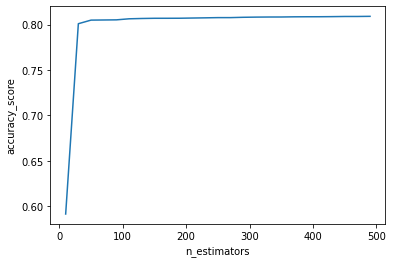

In [ ]:
plt.plot((param["n_estimators"]), [elem for elem in gs.cv_results_["mean_test_score"]])
plt.xlabel("n_estimators")
plt.ylabel("accuracy_score")
plt.title('Изменение accuracy при росте количества деревьев')

По графику видно, что хорошая сходимость наблюдается уже начиная с 50 деревьев, далее качество незначительно растет (с небольшими колебаниями) -- я выбираю 100 деревьев (по умолчанию), так как они дают небольшой прирост в качестве, при этом несильно увеличив время работы

In [ ]:
param = {'learning_rate':[0.1, 1.0, 2.0, 3.0],
         'reg_lambda':[0.1, 1.0, 2.0, 3.0],
         'reg_alpha':[0.1, 1.0, 2.0, 3.0]}
gs = GridSearchCV(xgb.XGBClassifier(random_state=8, objective='binary:hinge',
                                    scale_pos_weight=disbalance, seed=8, num_boost_round=10,
                                    n_estimators=100),
                   param, make_scorer(accuracy_score), verbose=3, cv=3)

In [ ]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] learning_rate=0.1, reg_alpha=0.1, reg_lambda=0.1 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, reg_alpha=0.1, reg_lambda=0.1, score=0.806, total=   5.6s
[CV] learning_rate=0.1, reg_alpha=0.1, reg_lambda=0.1 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV]  learning_rate=0.1, reg_alpha=0.1, reg_lambda=0.1, score=0.805, total=   5.7s
[CV] learning_rate=0.1, reg_alpha=0.1, reg_lambda=0.1 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s


[CV]  learning_rate=0.1, reg_alpha=0.1, reg_lambda=0.1, score=0.806, total=   5.6s
[CV] learning_rate=0.1, reg_alpha=0.1, reg_lambda=1.0 ................
[CV]  learning_rate=0.1, reg_alpha=0.1, reg_lambda=1.0, score=0.806, total=   5.7s
[CV] learning_rate=0.1, reg_alpha=0.1, reg_lambda=1.0 ................
[CV]  learning_rate=0.1, reg_alpha=0.1, reg_lambda=1.0, score=0.809, total=   5.7s
[CV] learning_rate=0.1, reg_alpha=0.1, reg_lambda=1.0 ................
[CV]  learning_rate=0.1, reg_alpha=0.1, reg_lambda=1.0, score=0.806, total=   5.6s
[CV] learning_rate=0.1, reg_alpha=0.1, reg_lambda=2.0 ................
[CV]  learning_rate=0.1, reg_alpha=0.1, reg_lambda=2.0, score=0.805, total=   5.6s
[CV] learning_rate=0.1, reg_alpha=0.1, reg_lambda=2.0 ................
[CV]  learning_rate=0.1, reg_alpha=0.1, reg_lambda=2.0, score=0.805, total=   5.6s
[CV] learning_rate=0.1, reg_alpha=0.1, reg_lambda=2.0 ................
[CV]  learning_rate=0.1, reg_alpha=0.1, reg_lambda=2.0, score=0.806, total= 

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed: 17.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, num_boost_round=10,
                                     objective='binary:hinge', random_state=8,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=is_canceled   1.68
dtype: float64,
                                     seed=8, silent=None, subsample=1,
                                     verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 1.0, 2.0,

In [ ]:
gs.best_params_

{'learning_rate': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 2.0}

Я выбираю параметры: learning_rate = 1.0, reg_alpha = 1.0, reg_lambda = 2.0

### XGBoost for DataFrame

In [ ]:
model1 = xgb.XGBClassifier(random_state=8, objective='binary:logistic',
                          scale_pos_weight=float(disbalance), seed=8, num_boost_round=10,
                          n_estimators=100, learning_rate=1.0, reg_alpha=1.0, reg_lambda=2.0)

In [ ]:
model1.fit(X_train, y_train, eval_metric='auc', verbose=True)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=1.0, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_boost_round=10, objective='binary:logistic',
              random_state=8, reg_alpha=1.0, reg_lambda=2.0,
              scale_pos_weight=1.6823111273124942, seed=8, silent=None,
              subsample=1, verbosity=1)

In [ ]:
roc_auc_score(y_test, model1.predict_proba(X_test)[:,1])

0.9052739811451859

In [ ]:
accuracy_score(y_test, model1.predict(X_test))

0.823701287670302

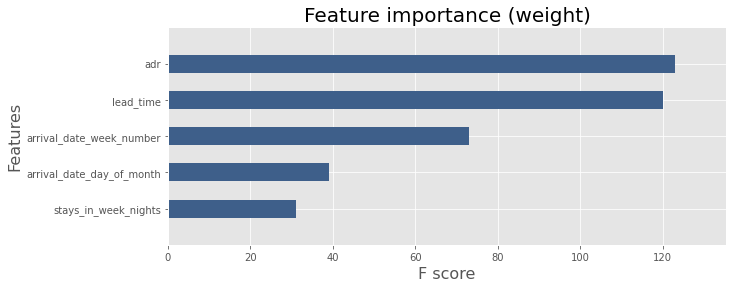

In [ ]:
xgb.plot_importance(model1,  height=0.5, max_num_features=5, title='Feature importance (weight)', importance_type='weight', color='#3E5F8A', show_values=False)

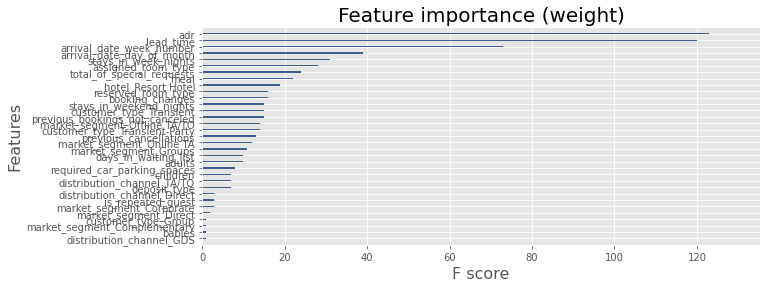

In [ ]:
xgb.plot_importance(model1, title='Feature importance (weight)', importance_type='weight', color='#3E5F8A', show_values=False)

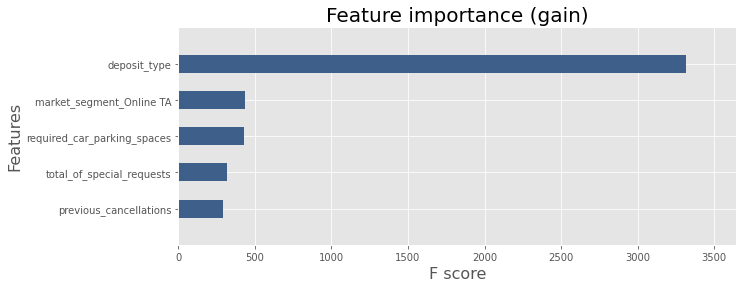

In [ ]:
xgb.plot_importance(model1, height=0.5, max_num_features=5,  title='Feature importance (gain)', importance_type='gain', color='#3E5F8A', show_values=False)

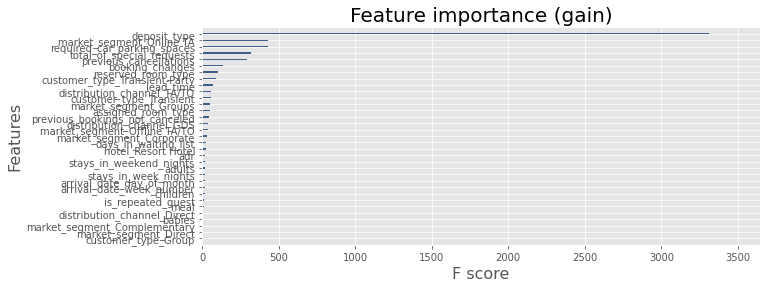

In [ ]:
xgb.plot_importance(model1, title='Feature importance (gain)', importance_type='gain', color='#3E5F8A', show_values=False)

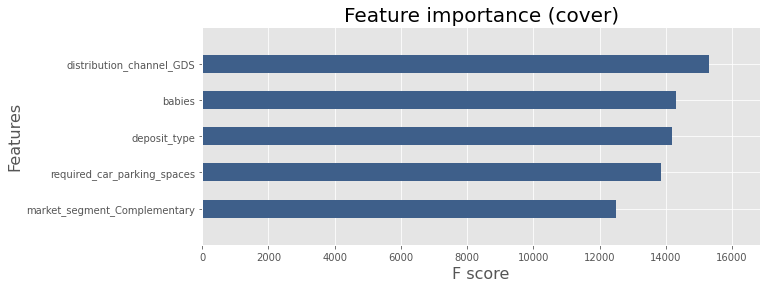

In [ ]:
xgb.plot_importance(model1, height=0.5,  max_num_features=5,  title='Feature importance (cover)', importance_type='cover', color='#3E5F8A', show_values=False)

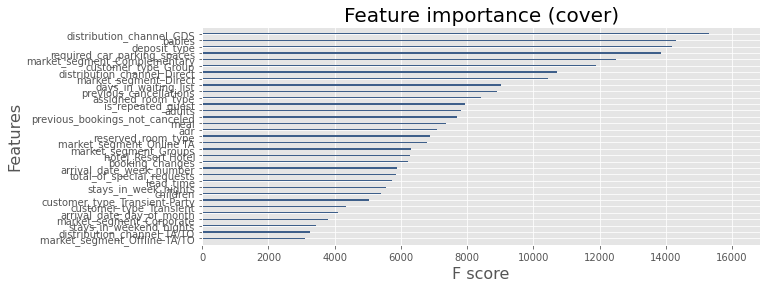

In [ ]:
xgb.plot_importance(model1, title='Feature importance (cover)', importance_type='cover', color='#3E5F8A', show_values=False)

### XGBoost for array

In [ ]:
model2 = xgb.XGBClassifier(random_state=8, objective='binary:logistic',
                          scale_pos_weight=float(disbalance), seed=8, num_boost_round=10,
                          n_estimators=100, learning_rate=1.0, reg_alpha=1.0, reg_lambda=2.0)

In [ ]:
model2.fit(X_train.values, y_train.values, eval_metric='auc', verbose=True)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=1.0, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_boost_round=10, objective='binary:logistic',
              random_state=8, reg_alpha=1.0, reg_lambda=2.0,
              scale_pos_weight=1.6823111273124942, seed=8, silent=None,
              subsample=1, verbosity=1)

## PDP

In [ ]:
#!pip install pdpbox

In [ ]:
from pdpbox import pdp

(<Figure size 864x576 with 3 Axes>,
 {'pdp_ax': {'_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f95d34048>,
   '_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f95ba0cf8>},
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f95e11eb8>})

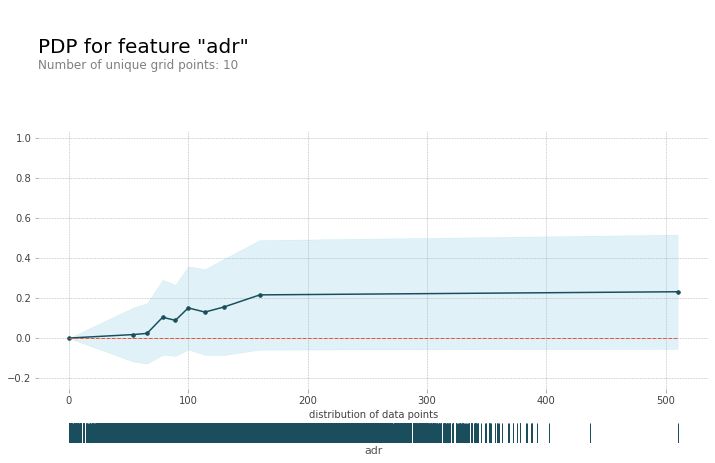

In [ ]:
pdp.pdp_plot(
    pdp.pdp_isolate(
        model=model1,
        dataset=X_train,
        model_features=X_train.columns,
        feature='adr', n_jobs=1
    ),
    feature_name='adr',
    plot_pts_dist=True,
    figsize=(12, 8), 
    plot_params={'title_fontsize': 20, 'fontsize':16}
)

(<Figure size 864x576 with 3 Axes>,
 {'pdp_ax': {'_count_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f95ca4be0>,
   '_pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f95c76940>},
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f95cbfef0>})

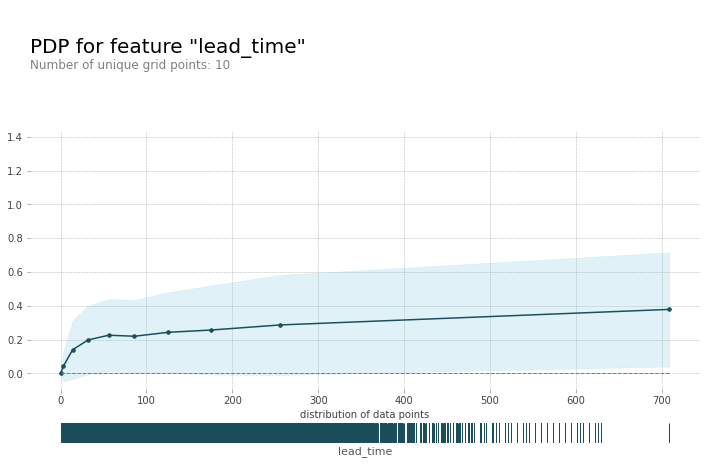

In [ ]:
pdp.pdp_plot(
    pdp.pdp_isolate(
        model=model1,
        dataset=X_train,
        model_features=X_train.columns,
        feature='lead_time', n_jobs=1
    ),
    feature_name='lead_time',
    plot_pts_dist=True, 
    figsize=(12, 8), 
    plot_params={'title_fontsize': 20, 'fontsize':16}
)

(<Figure size 864x576 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f92991eb8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f937a6860>})

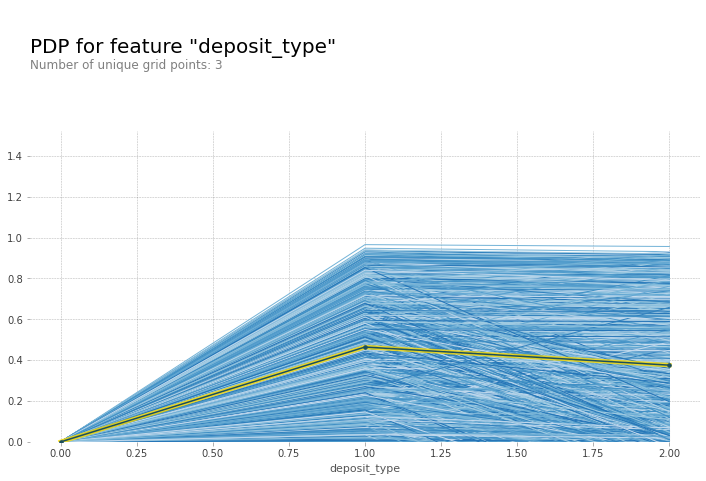

In [ ]:
pdp.pdp_plot(
    pdp.pdp_isolate(
        model=model1,
        dataset=X_train,
        model_features=X_train.columns,
        feature='deposit_type', n_jobs=1
    ),
    feature_name='deposit_type',
    cluster=True,
    n_cluster_centers=1000,
    plot_lines=True, 
    figsize=(12, 8), 
    plot_params={'title_fontsize': 20, 'fontsize':16}
)

(<Figure size 864x576 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f8f510438>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f92b35320>})

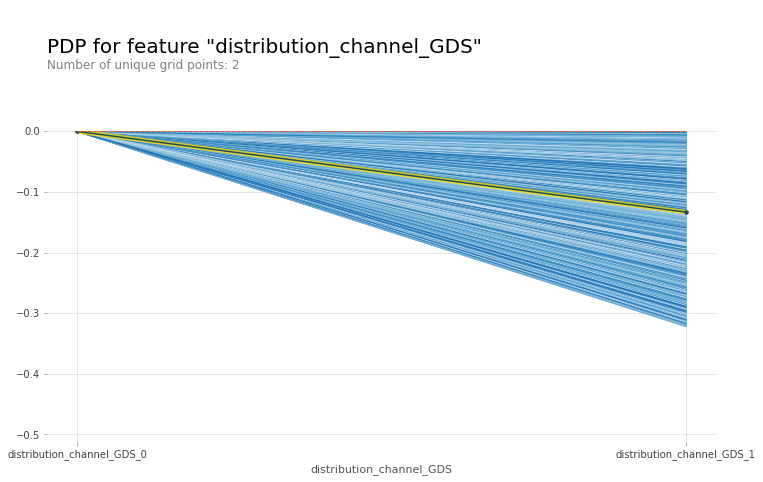

In [ ]:
pdp.pdp_plot(
    pdp.pdp_isolate(
        model=model1,
        dataset=X_train,
        model_features=X_train.columns,
        feature='distribution_channel_GDS', n_jobs=1
    ),
    feature_name='distribution_channel_GDS',
    cluster=True,
    n_cluster_centers=1000,
    plot_lines=True, 
    figsize=(12, 8), 
    plot_params={'title_fontsize': 20, 'fontsize':16}
)

(<Figure size 864x576 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f8e8ef1d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f9445c320>})

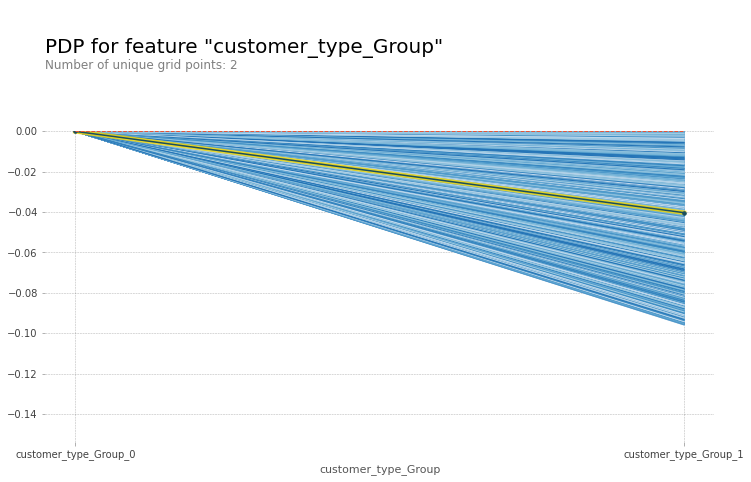

In [ ]:
pdp.pdp_plot(
    pdp.pdp_isolate(
        model=model1,
        dataset=X_train,
        model_features=X_train.columns,
        feature='customer_type_Group', n_jobs=1
    ),
    feature_name='customer_type_Group',
    cluster=True,
    n_cluster_centers=1000,
    plot_lines=True, 
    figsize=(12, 8), 
    plot_params={'title_fontsize': 20, 'fontsize':16}
)

(<Figure size 864x576 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f8dcd0940>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f8e97a978>})

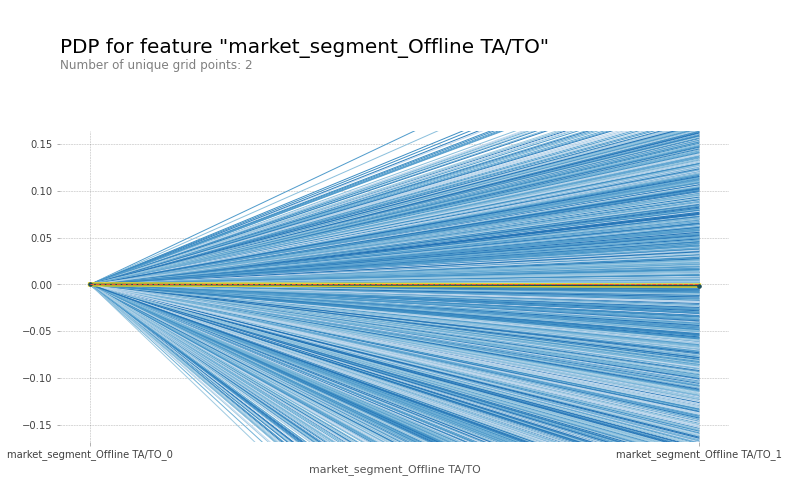

In [ ]:
pdp.pdp_plot(
    pdp.pdp_isolate(
        model=model1,
        dataset=X_train,
        model_features=X_train.columns,
        feature='market_segment_Offline TA/TO', n_jobs=1
    ),
    feature_name='market_segment_Offline TA/TO',
    cluster=True,
    n_cluster_centers=1000,
    plot_lines=True,  
    figsize=(12, 8), 
    plot_params={'title_fontsize': 20, 'fontsize':16}
)

In [ ]:
pdpdata = pdp.pdp_interact(model=model1, num_grid_points=[10, 10],
                           dataset=X_train,
                           model_features=X_train.columns,
                           features=['adr','lead_time'])

(<Figure size 756x900 with 5 Axes>,
 {'pdp_inter_ax': {'_pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f8d16b320>,
   '_pdp_x_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f8cf565c0>,
   '_pdp_y_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f8d0f77f0>},
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f8d2c0278>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


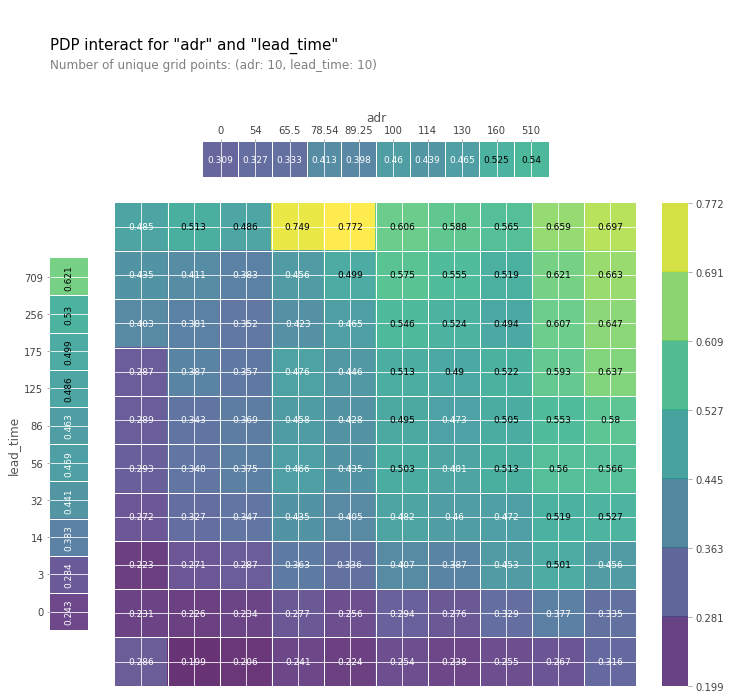

In [ ]:
pdp.pdp_interact_plot(pdpdata,
                      feature_names=['adr','lead_time'],
                      plot_type='grid',
                      plot_pdp=True)

TypeError: ignored

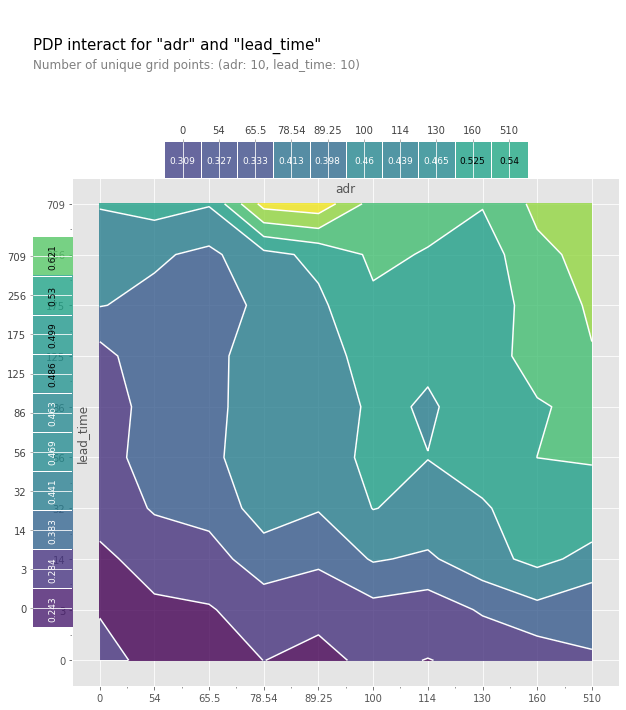

In [ ]:
# здесь появляется ошибка -- это нормально
pdp.pdp_interact_plot(pdpdata,feature_names=['adr','lead_time'], plot_pdp=True)

In [ ]:
pdpdata = pdp.pdp_interact(model=model1, num_grid_points=[10, 10],
                           dataset=X_train,
                           model_features=X_train.columns,
                           features=['market_segment_Offline TA/TO','lead_time'])

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f8befc748>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f4f8c0cbc88>})

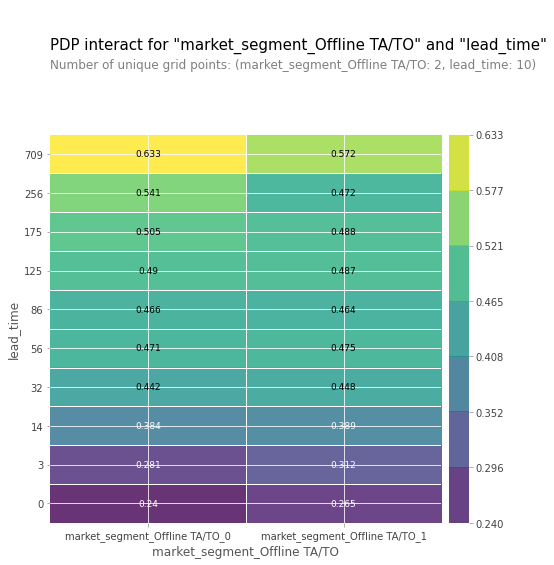

In [ ]:
pdp.pdp_interact_plot(pdpdata,
                      feature_names=['market_segment_Offline TA/TO','lead_time'],
                      plot_type='grid')

TypeError: ignored

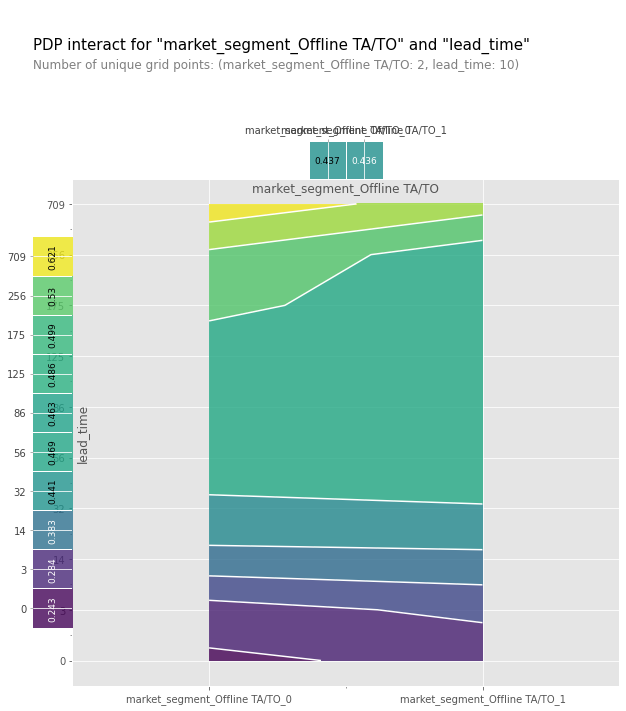

In [ ]:
# здесь появляется ошибка -- это нормально
pdp.pdp_interact_plot(pdpdata,feature_names=['market_segment_Offline TA/TO','lead_time'], plot_pdp=True)

## LIME

In [ ]:
#!pip install lime

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
explainer = LimeTabularExplainer(training_data=X_train.values,
                                 mode='classification', 
                                 feature_names=X_train.columns,
                                 categorical_features=categorical_features,
                                 verbose=True, 
                                 random_state=8,
                                 class_names=['not cancelled', 'is cancelled'])

In [ ]:
exp = explainer.explain_instance(X_train.values[0], model2.predict_proba, num_features=5)

Intercept 0.6635935798337957
Prediction_local [0.34029732]
Right: 0.5991428


In [ ]:
print('Истинное значение для данного объекта:', y_train.values[0][0], '-- бронь не была отменена ')

Истинное значение для данного объекта: 0 -- бронь не была отменена 


In [ ]:
exp.show_in_notebook()

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
explainer = LimeTabularExplainer(training_data=X_train.values,
                                 mode='classification', 
                                 feature_names=X_train.columns,
                                 categorical_features=categorical_features,
                                 verbose=True, 
                                 random_state=8,
                                 class_names=['not cancelled', 'is cancelled'])

## SHAP

In [ ]:
#!pip install shap

In [ ]:
import shap

### KernelSHAP

In [ ]:
%%time
f = lambda x: model2.predict_proba(x)[:,1]
kernel = shap.KernelExplainer(f, shap.kmeans(X_train.values, 100))

CPU times: user 2min 17s, sys: 1min 27s, total: 3min 45s
Wall time: 1min 55s


In [ ]:
%%time
shap_values = kernel.shap_values(X_train.values[:1000], nsamples=200, l1_reg='num_features(10)')


CPU times: user 3min 12s, sys: 1min 36s, total: 4min 48s
Wall time: 2min 55s


In [ ]:
shap.initjs()
shap.force_plot(kernel.expected_value, shap_values[0], X_train.loc[X_train.index[0]], out_names=['is cancelled', 'not cancelled'])

In [ ]:
shap.initjs()
shap.force_plot(kernel.expected_value, shap_values[:200], X_train.values[:200], feature_names=X_train.columns, figsize=(18,3))

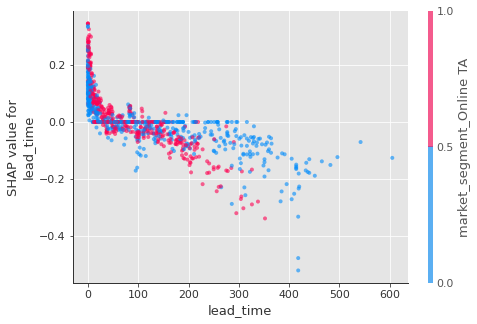

In [ ]:
shap.initjs()
shap.dependence_plot("lead_time", shap_values, X_train.iloc[:1000], alpha=0.6)

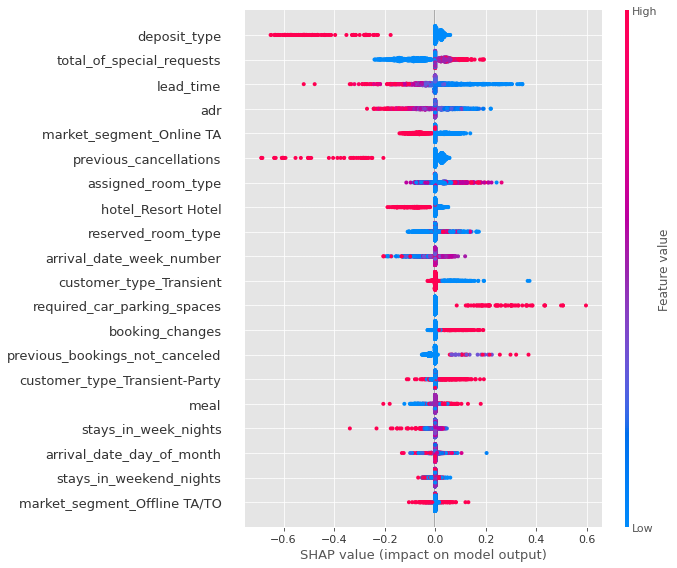

In [ ]:
shap.summary_plot(shap_values, X_train.iloc[:1000])

### TreeSHAP

In [ ]:
%%time
tree = shap.TreeExplainer(model2, shap.kmeans(X_train.values, 100), model_output='probability')

CPU times: user 2min 15s, sys: 1min 26s, total: 3min 41s
Wall time: 1min 54s


In [ ]:
%%time
tree_shap_values = tree.shap_values(X_train.values, y_train, tree_limit=100)

 99%|===================| 87626/88299 [02:10<00:00]       

CPU times: user 2min 9s, sys: 238 ms, total: 2min 10s
Wall time: 2min 10s


In [ ]:
shap.initjs()
shap.force_plot(tree.expected_value, tree_shap_values[0], X_train.loc[X_train.index[0]], out_names=['is cancelled', 'not cancelled'])

In [ ]:
shap.initjs()
shap.force_plot(tree.expected_value, tree_shap_values[:200], X_train.values[:200], feature_names=X_train.columns, figsize=(18,3))

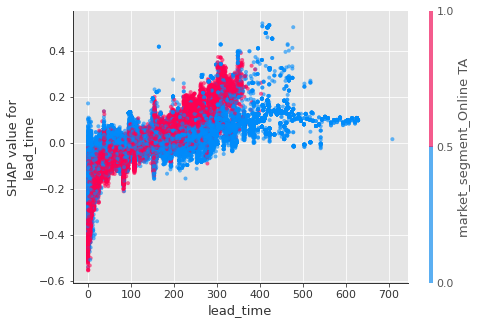

In [ ]:
shap.initjs()
shap.dependence_plot("lead_time", tree_shap_values, X_train, alpha=0.6)

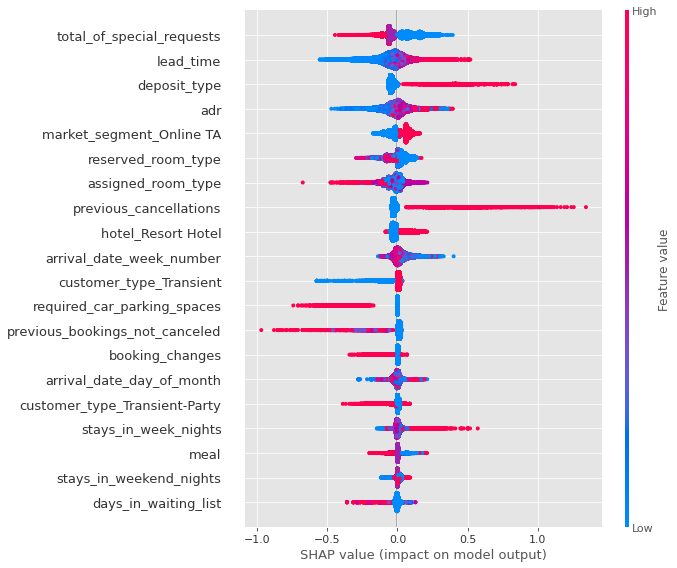

In [ ]:
shap.summary_plot(tree_shap_values, X_train)